<a href="https://colab.research.google.com/github/jblanco89/MonteCarlo_Portfolio/blob/main/portfolio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pycoingecko 

In [2]:
import pandas as pd
import pandas_datareader.data as pdr
import numpy as np
import matplotlib.pyplot as plt
import time
import StocksData as sd


Tickers for Portfolio

In [3]:
stocks = ['ltc', 'sol', 'cake', 'ada', 'ray'] 

In [4]:
prices = sd.get_data(stocks, '05/01/21', '10/08/21')
prices.tail()

,Timestamp,ltc,sol,cake,ada,ray
152,09/30/21 00:00:00,145.033389,141.183746,19.936825,2.247219,11.540420
153,10/01/21 00:00:00,153.145376,161.374029,20.112291,2.258839,11.157541
154,10/02/21 00:00:00,166.032984,169.208844,19.702350,2.195095,11.052585
155,10/03/21 00:00:00,169.658307,172.855870,19.368377,2.237849,10.768969
156,10/04/21 00:00:00,170.965270,167.877910,19.974564,2.213307,10.326866


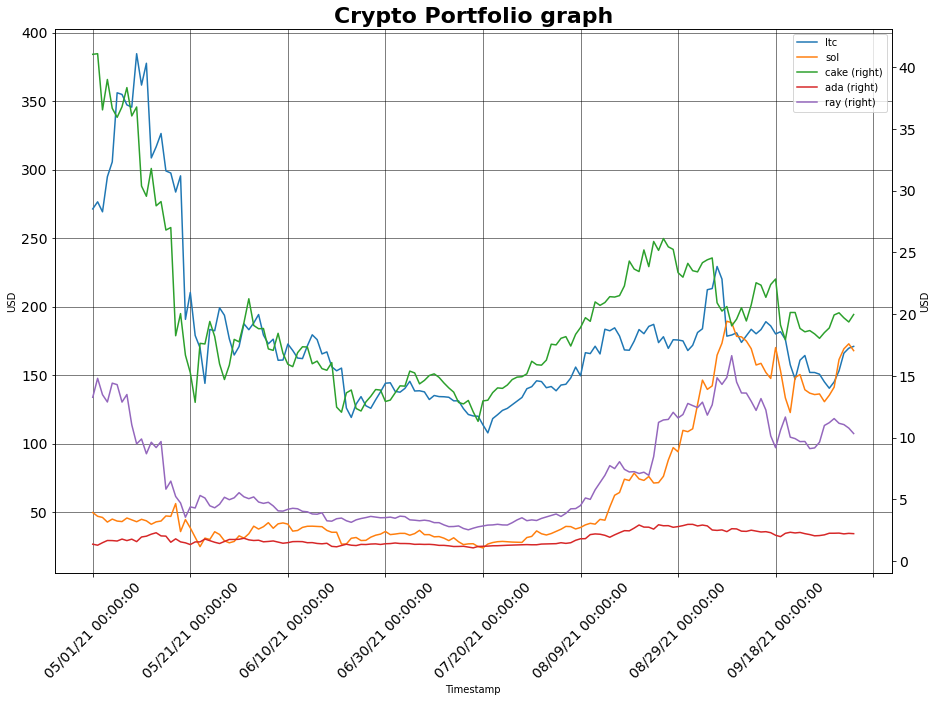

In [5]:
sd.plot_stock_data(prices)

In [6]:
#Calculating daily return 
def daily_returns(df):
    return (df.pct_change())

daily_rets = daily_returns(prices.drop('Timestamp', axis=1))

print(daily_rets.tail())



          ltc       sol      cake       ada       ray
152  0.032956  0.043647  0.055706  0.000200  0.029838
153  0.055932  0.143007  0.008801  0.005171 -0.033177
154  0.084153  0.048551 -0.020383 -0.028220 -0.009407
155  0.021835  0.021553 -0.016951  0.019477 -0.025661
156  0.007704 -0.028798  0.031298 -0.010967 -0.041053


In [7]:
#Setting function for calculting daily return for every selected coin

def mean_return(daily_returns):
    return (daily_returns.mean())

mean_return_rets = mean_return(daily_rets)
print(mean_return_rets.tail())


ltc    -0.000582
sol     0.011815
cake   -0.001825
ada     0.005396
ray     0.002379
dtype: float64


In [8]:
#creating covariance matrices

def covariance_matrix(daily_returns):
    return (daily_returns.cov())

cov_matrix_all = covariance_matrix(daily_rets)
print(cov_matrix_all)

           ltc       sol      cake       ada       ray
ltc   0.004519 -0.001092  0.000030 -0.000698  0.000675
sol  -0.001092  0.007862 -0.001333 -0.000263 -0.000936
cake  0.000030 -0.001333  0.005458 -0.000942  0.000480
ada  -0.000698 -0.000263 -0.000942  0.004596 -0.000175
ray   0.000675 -0.000936  0.000480 -0.000175  0.007734


In [9]:
# ------------------------------------------------------
# ------ MONTECARLO SIMULATION FUNCTION ----------------
# ------------------------------------------------------

#we must create a function to calculate returns, standard dev 
# and Sharpe ratios for speciefied randomly weighted portfolios

def results_dataframe(tickers, number_portfolios, mean_daily_returns, cov_matrix):
    results_temp = np.zeros((4 + len(tickers) - 1, number_portfolios))

    for i in range(number_portfolios):
        # select random weights for portfolio holdings
        weights = np.array(np.random.random(len(tickers)))
        
        # rebalance weights to sum to 1
        weights /= np.sum(weights)

        # calculate portfolio return and volatility
        portfolio_return = np.sum(mean_daily_returns * weights) * 252
        portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)

        # 3 month T-Bill yield used as risk free rate of return
        risk_free_return = 0.0139

        # store results in results array
        results_temp[0, i] = portfolio_return
        results_temp[1, i] = portfolio_std_dev
        
        # store Sharpe Ratio (return / volatility) - risk free rate element excluded for simplicity
        results_temp[2, i] = (results_temp[0, i] - risk_free_return) / results_temp[1, i]
        
        # iterate through the weight vector and add data to results array
        for j in range(len(weights)):
            results_temp[j + 3, i] = weights[j]

    # convert results array to Pandas DataFrame
    results_df = pd.DataFrame(results_temp.T, columns=['ret', 'stdev', 'sharpe', tickers[0], 
                                                       tickers[1], tickers[2],
                                                       tickers[3], tickers[4]])
    
    return results_df



In [10]:
results_crypto = results_dataframe(stocks,90000, mean_return_rets, cov_matrix_all)
print(results_crypto.tail())

            ret     stdev    sharpe  ...      cake       ada       ray
89995  1.625902  0.645161  2.498604  ...  0.070038  0.222745  0.244070
89996  0.934811  0.497002  1.852934  ...  0.284909  0.257453  0.189139
89997  1.032045  0.524722  1.940354  ...  0.085935  0.280584  0.270728
89998  0.897080  0.498641  1.771172  ...  0.096819  0.195845  0.218351
89999  0.699372  0.699165  0.980416  ...  0.000015  0.031842  0.326749

[5 rows x 8 columns]


In [11]:
#finding portfolio with the highest sharpe ratio

def max_sr(results_df):
    return results_df.iloc[results_df['sharpe'].idxmax()]

max_sharpe_portfolio = max_sr(results_crypto)
print(max_sharpe_portfolio)


ret       1.652114
stdev     0.618718
sharpe    2.647754
ltc       0.099773
sol       0.399191
cake      0.060058
ada       0.317580
ray       0.123398
Name: 74570, dtype: float64


In [12]:
#identifiying portfolio with the lowest volatility (stdev)

def min_vol(result_df):
    return result_df.iloc[result_df['stdev'].idxmin()]


In [13]:
min_vol_portfolio = min_vol(result_df=results_crypto)
print(min_vol_portfolio)

ret       0.831169
stdev     0.438072
sharpe    1.865607
ltc       0.237434
sol       0.188492
cake      0.219277
ada       0.253760
ray       0.101037
Name: 79421, dtype: float64


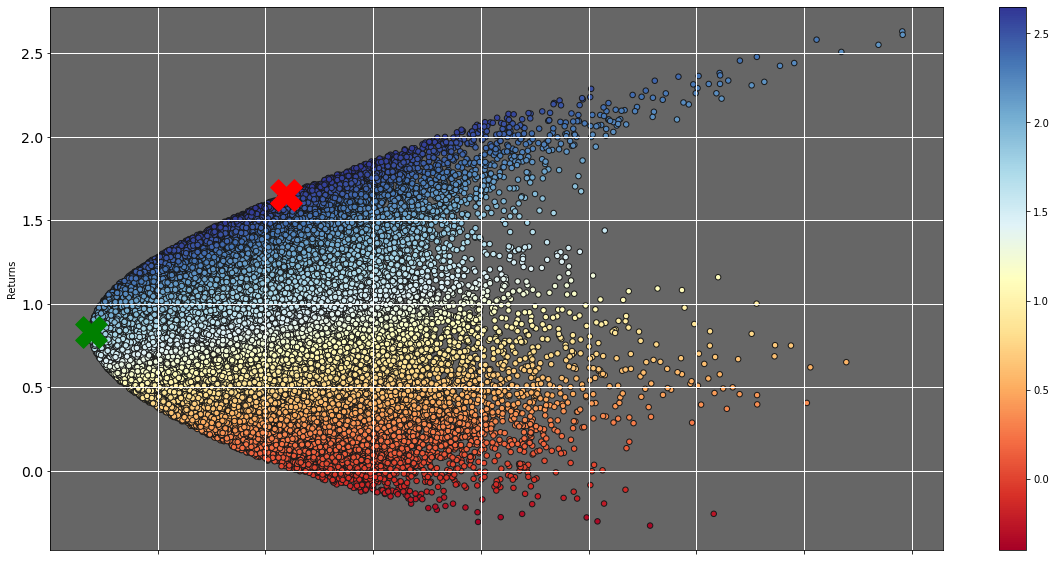

In [14]:
#Plot all different portfolio results with different weights

def plot_graph(results_df, max_sharpe_port, min_vol_port):
    ax = results_df.plot(kind= 'scatter', x = 'stdev', y='ret', s = 30, 
                         c=results_df.sharpe, cmap='RdYlBu',edgecolors='.1', figsize=(20,10))
    ax.grid(False, color='w', linestyle='-', linewidth=1)
    ax.set_facecolor('0.4')
    ax.set_xlabel('Volatility')
    ax.set_ylabel('Returns')
    ax.tick_params(labelsize = 14)

    # # plot red star to highlight position of portfolio with highest Sharpe Ratio
    ax.scatter(max_sharpe_port[1], max_sharpe_port[0], marker="X", color='r', s=1000)
    # # plot green star to highlight position of minimum variance portfolio
    ax.scatter(min_vol_port[1], min_vol_port[0], marker="X", color='g', s=1000)

plot_graph(results_crypto,max_sharpe_portfolio, min_vol_portfolio)
plt.show()

In [16]:
#Looking for real portfolio weight
real_portfolio = [0.05, 0.40, 0.10, 0.30, 0.10]
type(real_portfolio)

list

In [17]:
rf = results_crypto.iloc[:,[3,4,5,6,7]]
rf

,ltc,sol,cake,ada,ray
0,0.029600,0.019732,0.334373,0.020762,0.595533
1,0.262194,0.101273,0.410181,0.030008,0.196344
2,0.249956,0.180765,0.087549,0.207170,0.274559
3,0.030123,0.113841,0.252000,0.355564,0.248472
4,0.241966,0.221272,0.269583,0.158528,0.108650
...,...,...,...,...,...
89995,0.054437,0.408710,0.070038,0.222745,0.244070
89996,0.063076,0.205424,0.284909,0.257453,0.189139
89997,0.176787,0.185966,0.085935,0.280584,0.270728
89998,0.291761,0.197224,0.096819,0.195845,0.218351


In [18]:
rf_round = np.round(rf,decimals=2)
rf_round

,ltc,sol,cake,ada,ray
0,0.03,0.02,0.33,0.02,0.60
1,0.26,0.10,0.41,0.03,0.20
2,0.25,0.18,0.09,0.21,0.27
3,0.03,0.11,0.25,0.36,0.25
4,0.24,0.22,0.27,0.16,0.11
...,...,...,...,...,...
89995,0.05,0.41,0.07,0.22,0.24
89996,0.06,0.21,0.28,0.26,0.19
89997,0.18,0.19,0.09,0.28,0.27
89998,0.29,0.20,0.10,0.20,0.22


In [19]:
rf_round.isin(real_portfolio).any()

ltc     True
sol     True
cake    True
ada     True
ray     True
dtype: bool

In [20]:

weights = real_portfolio
results_temp = np.zeros((4 + len(stocks) - 1, 1))    
# rebalance weights to sum to 1
weights /= np.sum(weights)

# calculate portfolio return and volatility
portfolio_return = np.sum(mean_return_rets * weights) * 252
portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix_all, weights))) * np.sqrt(252)

# 3 month T-Bill yield used as risk free rate of return
risk_free_return = 0.0139

# store results in results array
results_temp[0, 0] = portfolio_return
results_temp[1, 0] = portfolio_std_dev
    
# store Sharpe Ratio (return / volatility) - risk free rate element excluded for simplicity
results_temp[2, 0] = (results_temp[0, 0] - risk_free_return) / results_temp[1, 0]
    
# iterate through the weight vector and add data to results array
for j in range(len(weights)):
  results_temp[j + 3, 0] = weights[j]

# convert results array to Pandas DataFrame
results_test_portfolio = pd.DataFrame(results_temp.T, columns=['ret', 'stdev', 'sharpe', stocks[0], 
                                                    stocks[1], stocks[2],
                                                    stocks[3], stocks[4]])

results_test_portfolio


,ret,stdev,sharpe,ltc,sol,cake,ada,ray
0,1.690031,0.637397,2.629649,0.052632,0.421053,0.105263,0.315789,0.105263


In [21]:
def plot_graph_test(results_df, max_sharpe_port, min_vol_port, results_test):
    ax = results_df.plot(kind= 'scatter', x = 'stdev', y='ret', s = 40, 
                         c=results_df.sharpe, cmap='RdYlBu',edgecolors='.1', 
                         figsize=(20,10))
    ax.grid(False, color='w', linestyle='-', linewidth=1)
    ax.set_facecolor('0.4')
    ax.set_title("MonteCarlo simulation with real portfolio", fontsize=22, 
                 fontweight='bold')
    ax.set_xlabel('Volatility', fontsize = 14)
    ax.set_ylabel('Returns', fontsize = 14)
    ax.tick_params(labelsize = 14) 

    # # plot red star to highlight position of portfolio with highest Sharpe Ratio
    ax.scatter(max_sharpe_port[1], max_sharpe_port[0], marker="X", color='darkred', s=700)
    # # plot green star to highlight position of minimum variance portfolio
    ax.scatter(min_vol_port[1], min_vol_port[0], marker="X", color='b', s=700)

    rt = results_test.values

    ax.scatter(rt[0,1], rt[0,0], marker = "X", color = 'k', s=700)




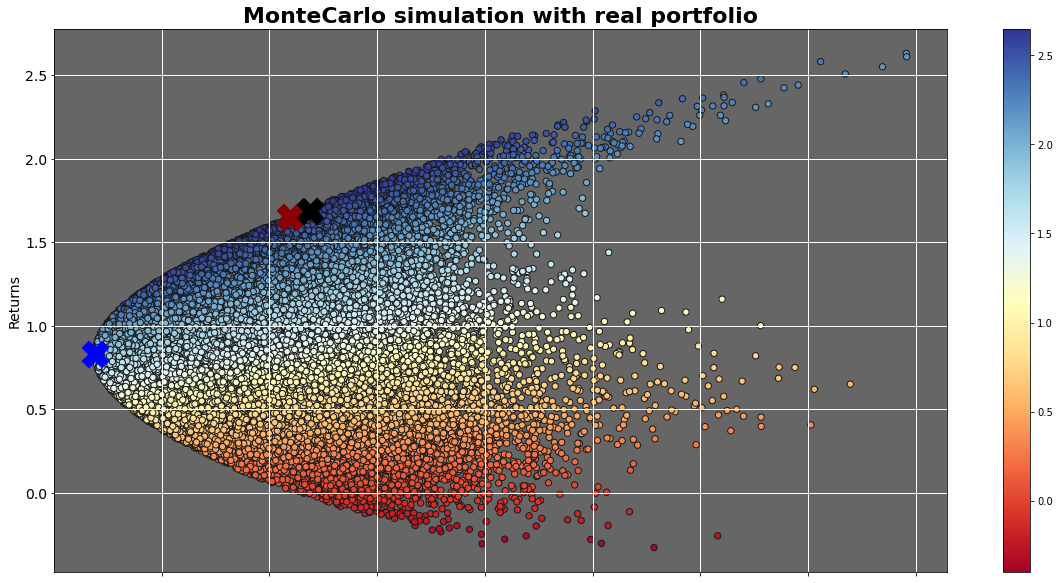

In [22]:
plot_graph_test(results_crypto, max_sharpe_portfolio, min_vol_portfolio, results_test_portfolio)
plt.show()

In [ ]:
%%shell
jupyter nbconvert --to html /content/portfolio.ipynb


[NbConvertApp] Converting notebook /content/portfolio.ipynb to html
[NbConvertApp] Writing 1224186 bytes to /content/portfolio.html
